# Thesis Data Analysis — Reconciling Tilt Estimates from Mapping and Modelling

## Setup

The following cells set up the machinery for reading and analyzing the model output data. First, I import modules.

In [8]:
# read .csv
from svglib.svglib import svg2rlg

# computation & data structures
import numpy as np
from math import *
import itertools
import pandas as pd
import glob

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.graphics import renderPDF
import os
import shutil

This cell handles the GIS output. Most of the attributes have already been calculated, so the main purpose of this code is to examine subsets of the data (center points, sample locations, distances) and evaluate each inflation center by a few different criteria (fraction of data explainable, fraction explainable within certain tilt constraints, etc.). I will eventually export a new table with these criteria for exporting back into GIS and exploring where those best candidates actually end up. And of course I explore everything though plotting here as well.

'figures/plot.pdf'

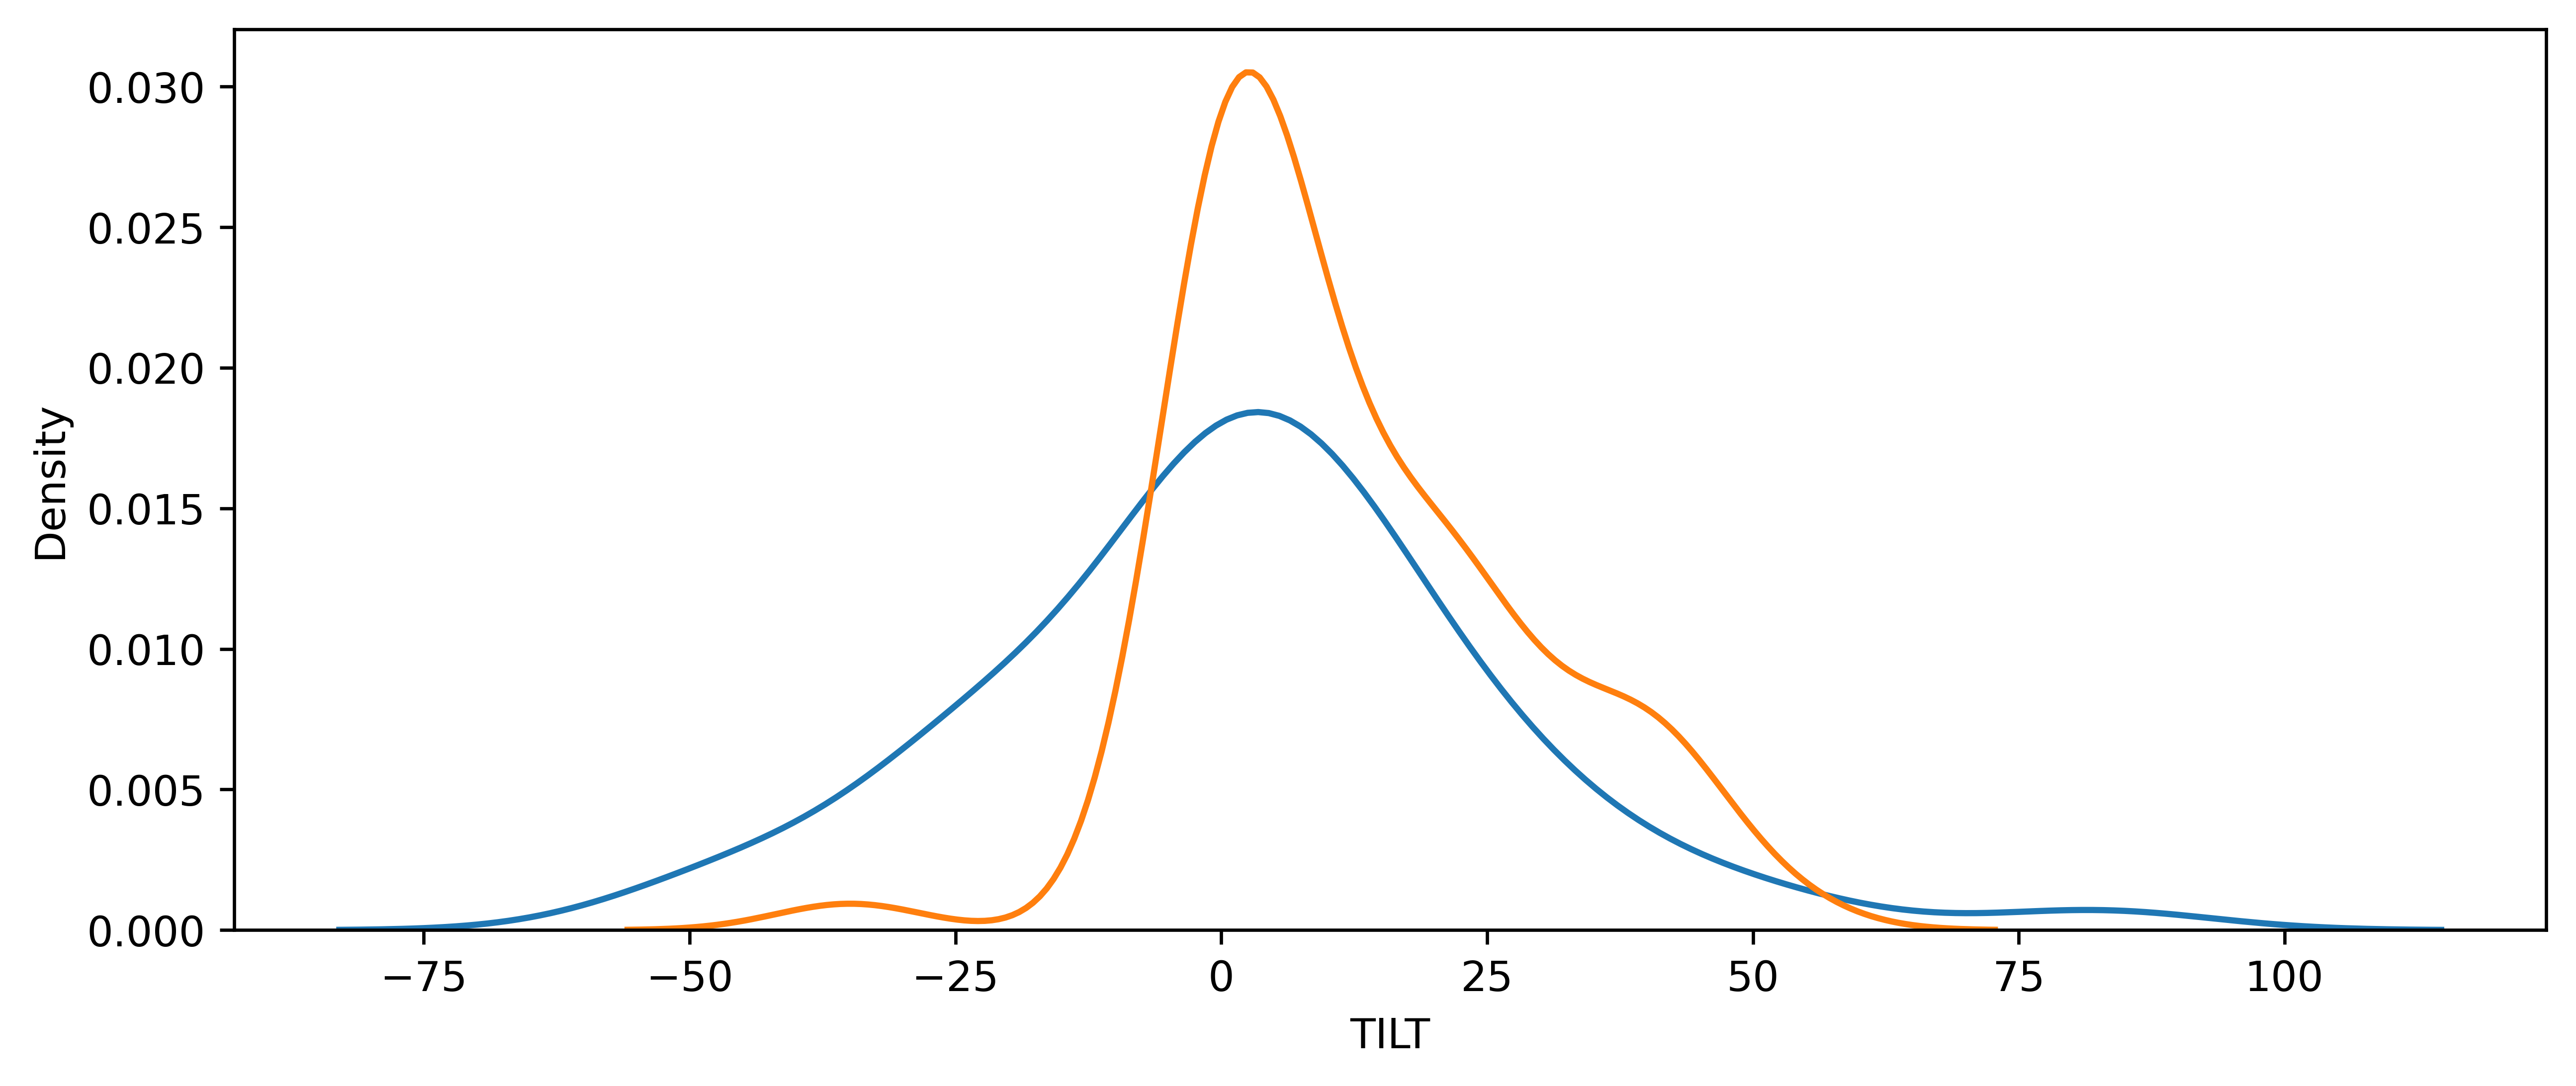

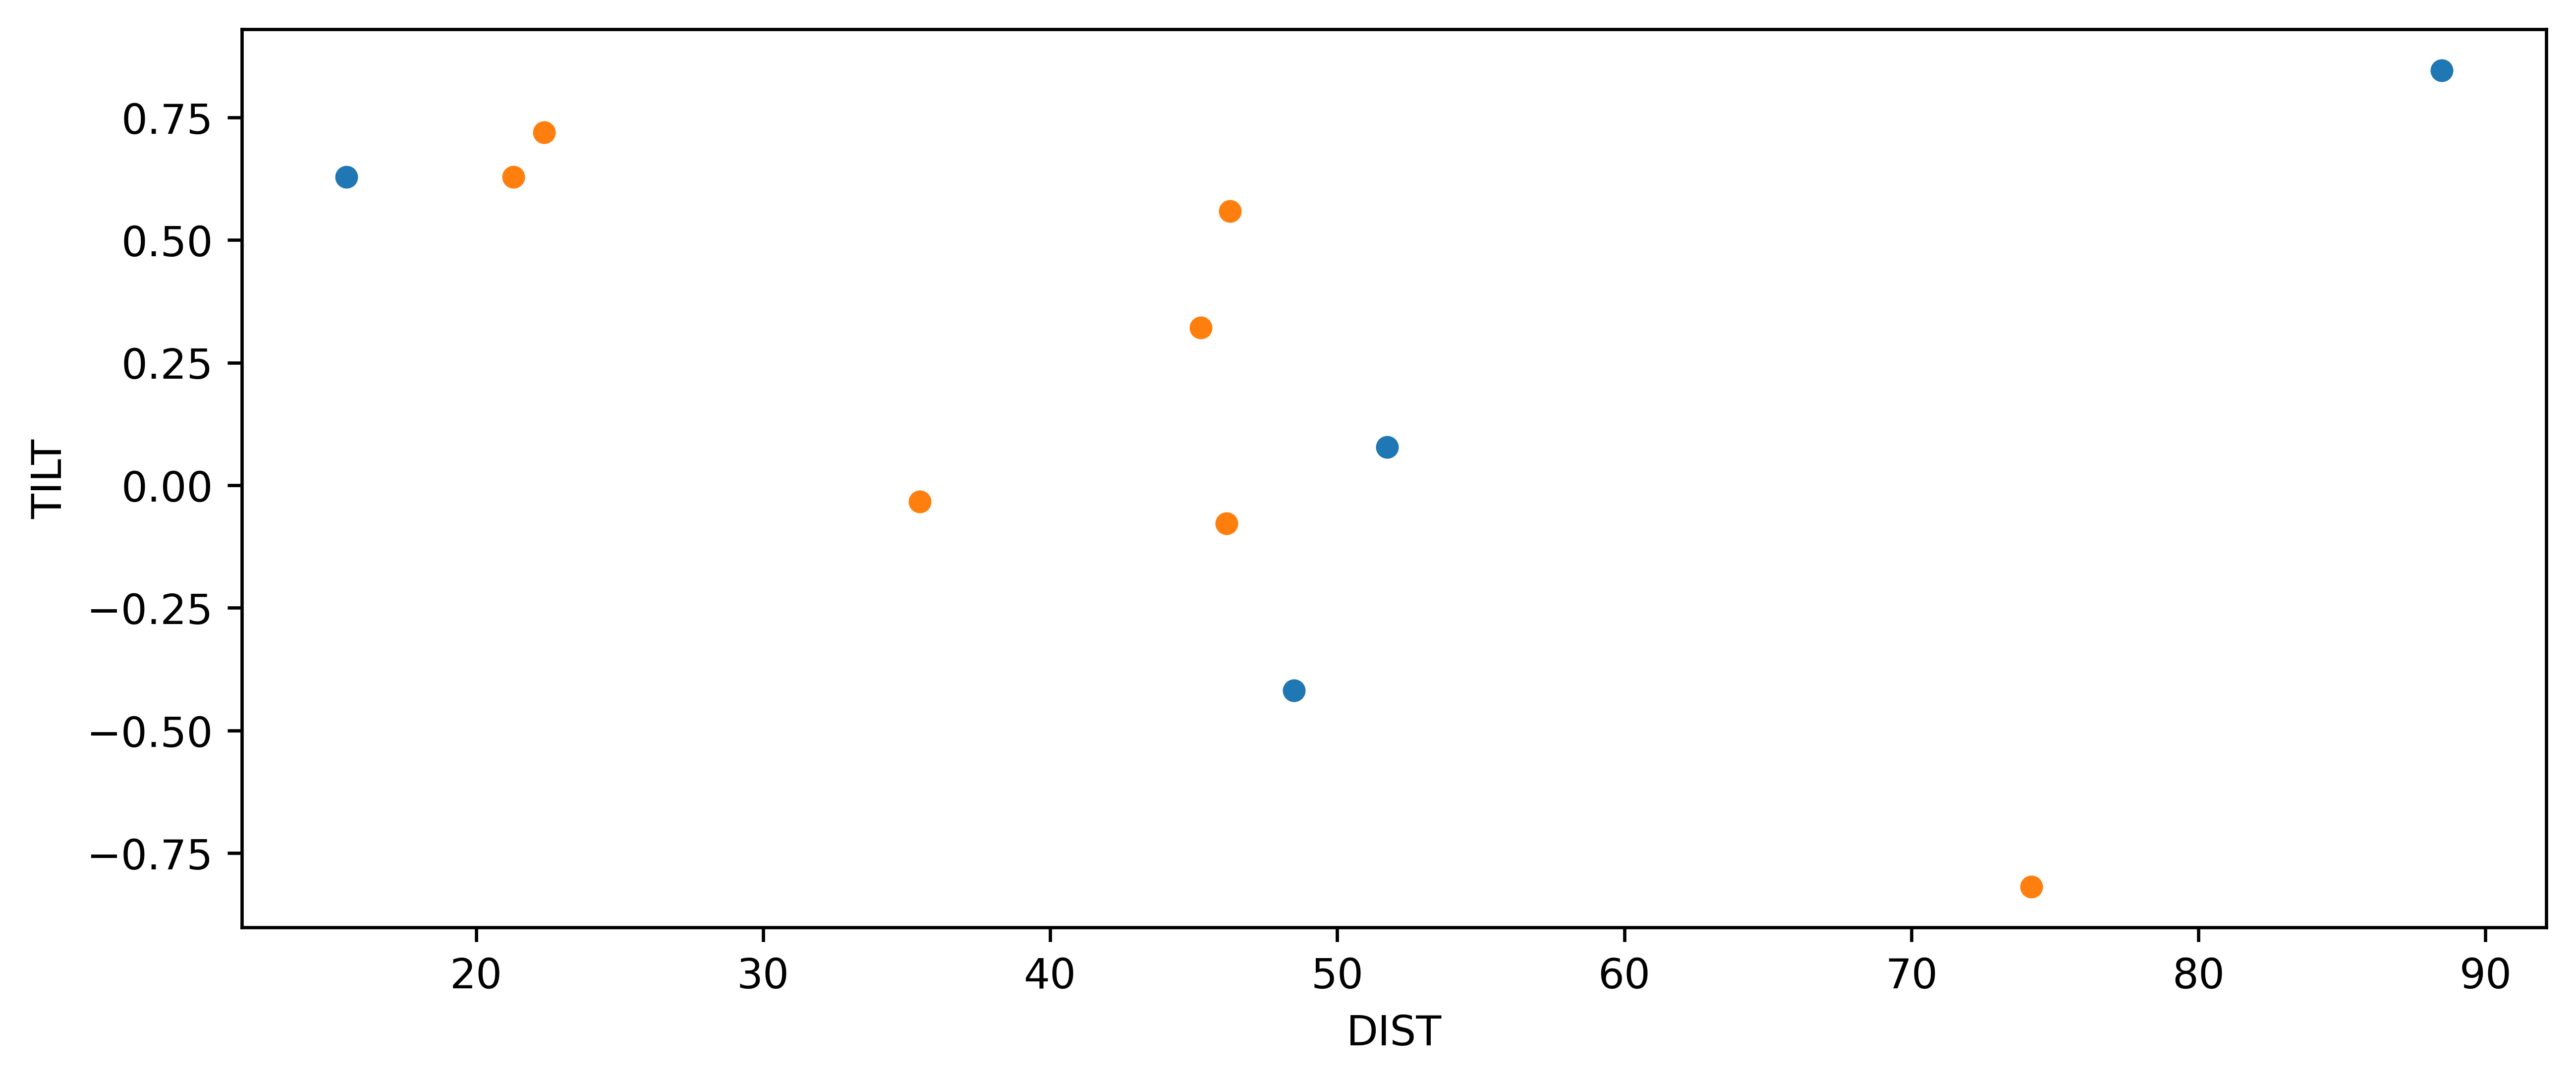

In [10]:
# location to read .csv files
map_data_location = "../GEOL192-GIS/data/"

# define a function for reading output .csv files (attribute tables in GIS) 
def map_data_from_csv(feature, num):
    return pd.read_csv(f"{map_data_location}{feature}_{str(num)}.csv")

# find all the .csv files in location 
map_filenames = glob.glob(map_data_location + "*.csv")
map_nums = [int(name.split('_')[2].split('.')[0]) for name in map_filenames]

# list of sample IDS to include in analysis. Fill this with most displaced southern flows 
sample_subset = None

# realistic tilt value
max_tilt = 1

# object that stores data associated with a particular center point analysis
class CenterPoint():
    def __init__(self, feature, center_ID, sample_subset=None) -> None:
        self.ID = center_ID
        self.data = map_data_from_csv(feature, center_ID)

        # take only a subset of points if desired
        if sample_subset is not None:
            self.data = self.data.loc[self.data['OID_'].isin(sample_subset)]

        self.data_realistic = self.data[np.abs(self.data['TILT']) < max_tilt]

        # correct distances to km and add other key attributes to object
        self.dist = self.data.DIST / 1000
        self.tilt = self.data.TILT

        # correct distances to km and add other key attributes to object
        self.dist_realistic = self.data_realistic.DIST / 1000
        self.tilt_realistic = self.data_realistic.TILT

        # inflation center evaluation criteria:
        # what fraction of the terms are not errors
        self.criteria = {
            'frac_possible': self.data['TILT'].notnull().sum() / len(self.data),
            'frac_realistic': self.data_realistic['TILT'].notnull().sum() / len(self.data),
            'mean': self.data['TILT'][self.data['TILT'].notnull()].mean(),
            'std': self.data['TILT'][self.data['TILT'].notnull()].std()
        }

# make an object for each center point
flow_data = [CenterPoint("flow_subset", num, sample_subset) for num in map_nums]

center_subset = [4,101]

fig_map_kde = plt.figure(figsize = (10, 4), dpi = 600)

for i in center_subset:
    sns.kdeplot(data=flow_data[i].tilt)

fig_map_scatter = plt.figure(figsize = (10, 4), dpi = 600)

for i in center_subset:
    sns.scatterplot(x=flow_data[i].dist_realistic, y=flow_data[i].tilt_realistic)


# save as .svg
fig_map_kde.savefig("plot.svg")

# .svg to .pdf 
renderPDF.drawToFile(svg2rlg("plot.svg"), "plot.pdf")
os.remove("plot.svg")
shutil.move('plot.pdf','figures')

Then, I define functions for reading the starting positions and displacements (radial and vertical components) of mesh vertices as expressed in the COMSOL files. While this script handles further calculations for the models, I simply read in the values calculated for each centerpoint from the GIS output.

In [3]:
# constants in SI units
SHEAR_MODULUS = 2.4e10
ROCK_DENSITY = 2700
MAGMA_DENSITY = 2700
MARS_GRAVITY = 3.72
PLOT_WIDTH = 100_000

model_data_location = "../GEOL192-Model/data/"

def model_pos1_from_csv(string):
    r = np.genfromtxt(model_data_location + "r_" + string, delimiter= ",")[:,0]
    z = np.zeros(len(r)) # FIXME
    return np.array([r, z]).T

def model_disp_from_csv(string):
    r = np.genfromtxt(model_data_location + "r_" + string, delimiter= ",")[:,1]
    z = np.genfromtxt(model_data_location + "z_" + string, delimiter= ",")[:,1]
    return np.array([r, z]).T


I include functions for displacement and angular tilt from an analytical solution which assumes a elastic half-space inflated by a spherical reservoir, for comparison.

In [4]:
def mogi_disp(overpressure, reservoir_radius, depth_to_center, radial_distance):
    d = depth_to_center
    r = radial_distance
    common_term = 3 * reservoir_radius**3 * overpressure / (4 * SHEAR_MODULUS * (d**2 + r**2)**1.5)
    disp_r = common_term * r
    disp_z = common_term * d
    return np.array(disp_r, disp_z)

def mogi_tilt(overpressure, reservoir_radius, depth_to_center, radial_distance):
    '''analytical check for spherical reservoir in elastic half-space. Confirms numerical model accuracy and that the olympus mons edifice geometry is not very important, at least for horizontal treatment'''
    a = 3 * reservoir_radius**3 * overpressure / (4 * SHEAR_MODULUS)
    d = depth_to_center
    r = radial_distance
    numerator = 3 * a * d * r
    denominator = (d**2 + r**2)**2.5 + a * d**2 - 2 * a * r**2
    return degrees(atan2(numerator, denominator))

Then I define classes for displaced vertices and surface elements (the latter defined by a consecutive pair of the former). These classes are primarily used to handle the radial tilt calculation.

In [5]:
class Vertex():
    def __init__(self, pos1, disp):
        self.pos1 = pos1
        self.disp = disp
        self.pos2 = self.pos1 + self.disp

class Element():
    def __init__(self, proximal_vertex, distal_vertex):

        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = distal_vertex.pos1 - proximal_vertex.pos1
        self.shape2 = distal_vertex.pos2 - proximal_vertex.pos2

        # mean position of initial and displaced segments
        self.pos1 = (distal_vertex.pos1 + proximal_vertex.pos1) / 2
        self.pos2 = (distal_vertex.pos2 + proximal_vertex.pos2) / 2

        # radial distances for plotting
        self.r1_km = self.pos1[0] / 1000
        self.r2_km = self.pos2[0] / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = degrees(atan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = degrees(atan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1


Finally, a model class is initialized by a combination of parameters (geometry, overpressure) which reads the relevant .csv files, builds the vertices and elements, and converts the element attributes (position, displacement, tilt) into lists for plotting or further analysis.

In [6]:
class Model():
    def __init__(self, depth_to_top, horizontal_radius, vertical_radius, mult):

        self.params = {
            "DtT": depth_to_top,
            "Ra": horizontal_radius,
            "Rb": vertical_radius,
            "mult": mult
        }

        self.overpressure = mult * depth_to_top * ROCK_DENSITY * MARS_GRAVITY

        filename = f"DtT_{depth_to_top}_Ra_{horizontal_radius}_Rb_{vertical_radius}_mult_{mult}_gmult_0.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # build vertices from pos1 and disp if pos1 within defined length
        self.num_vertices = next(i for i, val in enumerate(self.pos1) if val[0] > PLOT_WIDTH)
        self.vertices = [Vertex(self.pos1[i], self.disp[i]) for i in range(self.num_vertices)]

        # build elements from consecutive vertex pairs
        self.vertex_pairs = zip(self.vertices[:-1], self.vertices[1:])
        self.elements = [Element(*pair) for pair in self.vertex_pairs]

        # put element attributes into dict of lists
        self.attributes = pd.DataFrame([vars(element) for element in self.elements]).to_dict("list")

# Model Output Analysis

I define the model parameter combinations used in COMSOL and build a Model class (defined above) from each geometry. Any subset of geometries can be used by removing elements from the parameter sets.

In [7]:
# parameter sweep in SI units
param_sweep = {
    "DtT": [10_000],
    "Ra": [50_000],
    "Rb": [10_000],
    "mult": [.8, .4, -.4, -.8]
}

# parameters which are constant for all models (just one value given above) will be listed in the figure title
constant_params = {key:val[0] for key,val in param_sweep.items() if len(val) == 1}
# parameters which vary for each model will be labeled accordingly
variable_params = [key for key, val in param_sweep.items() if len(val) > 1]

# build model object from all parameter combinations
geometries = itertools.product(*param_sweep.values())
models = [Model(*geometry) for geometry in geometries]

# Plotting and Comparison with Map Data

Finally, I plot numerical model outputs alongside map-derived sample data:

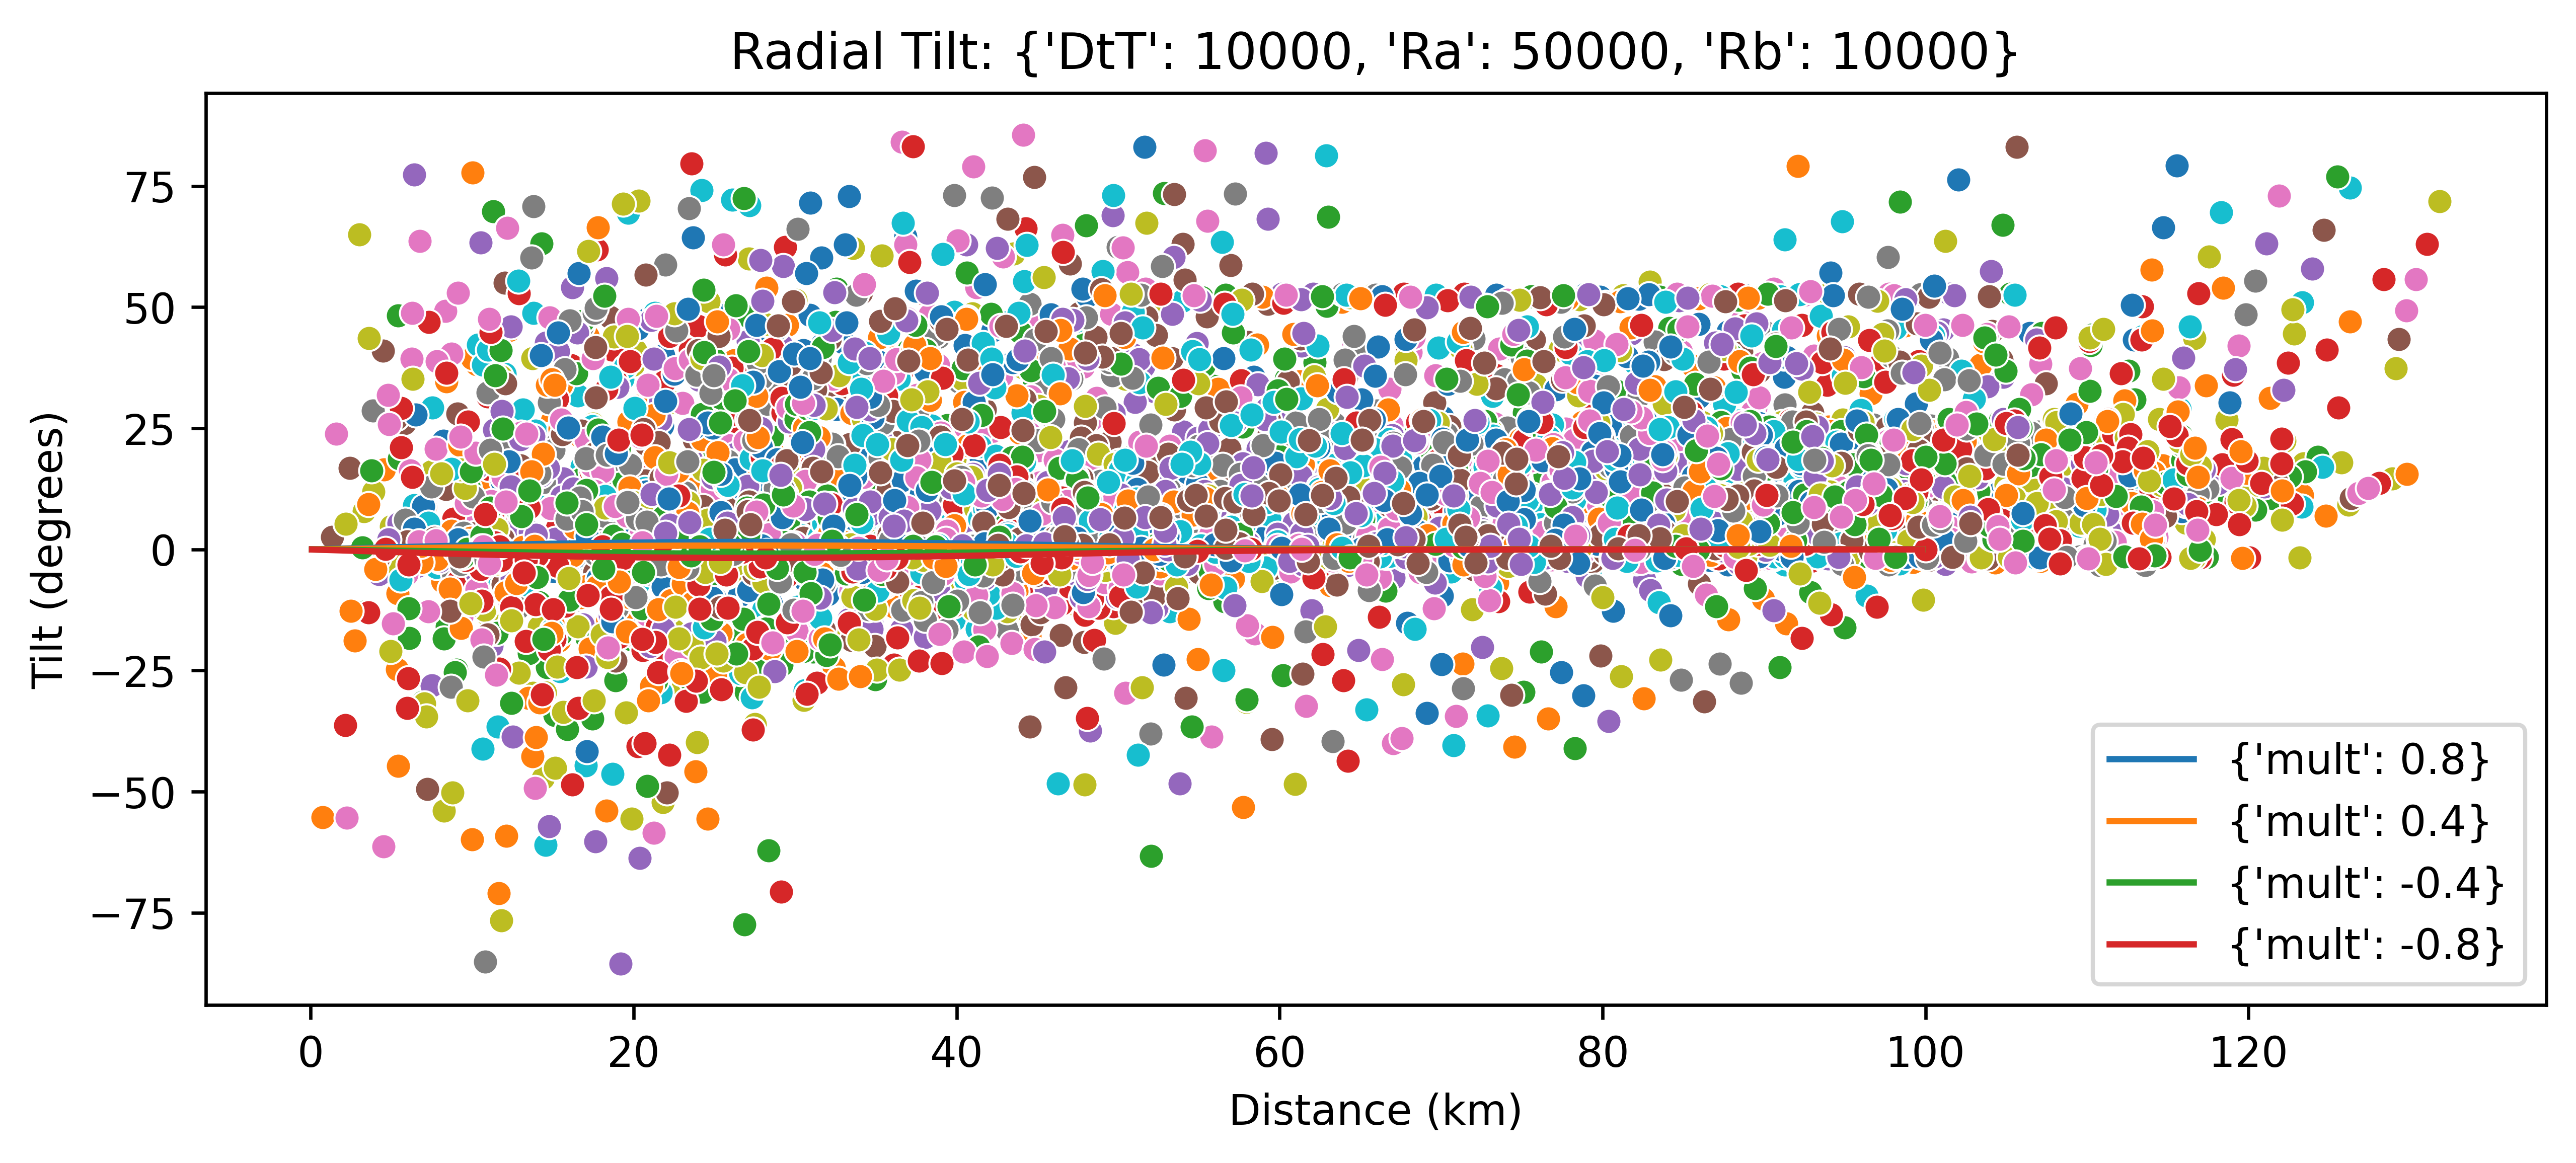

In [12]:
# plot figure
fig = plt.figure(figsize = (10, 4), dpi = 600)

# plot model data
for model in models:
    sns.lineplot(data=model.attributes, y="tilt", x = "r2_km", label={param:model.params[param] for param in variable_params})

max_tilt = 90

data_to_plot = flow_data[40:]


# plot map data
for data in data_to_plot:
    sns.scatterplot(data=data.loc[(abs(data['TILT']) < max_tilt)], x="DIST", y="TILT")

plt.title(f"Radial Tilt: {constant_params}")
plt.xlabel("Distance (km)")
plt.ylabel("Tilt (degrees)")
plt.legend(loc="lower right")

# save as .svg
# fig.savefig("figures/plot.svg")

# .svg to .pdf 
# renderPDF.drawToFile(svg2rlg("plot.svg"), "plot.pdf")
# os.remove("figures/plot.svg")

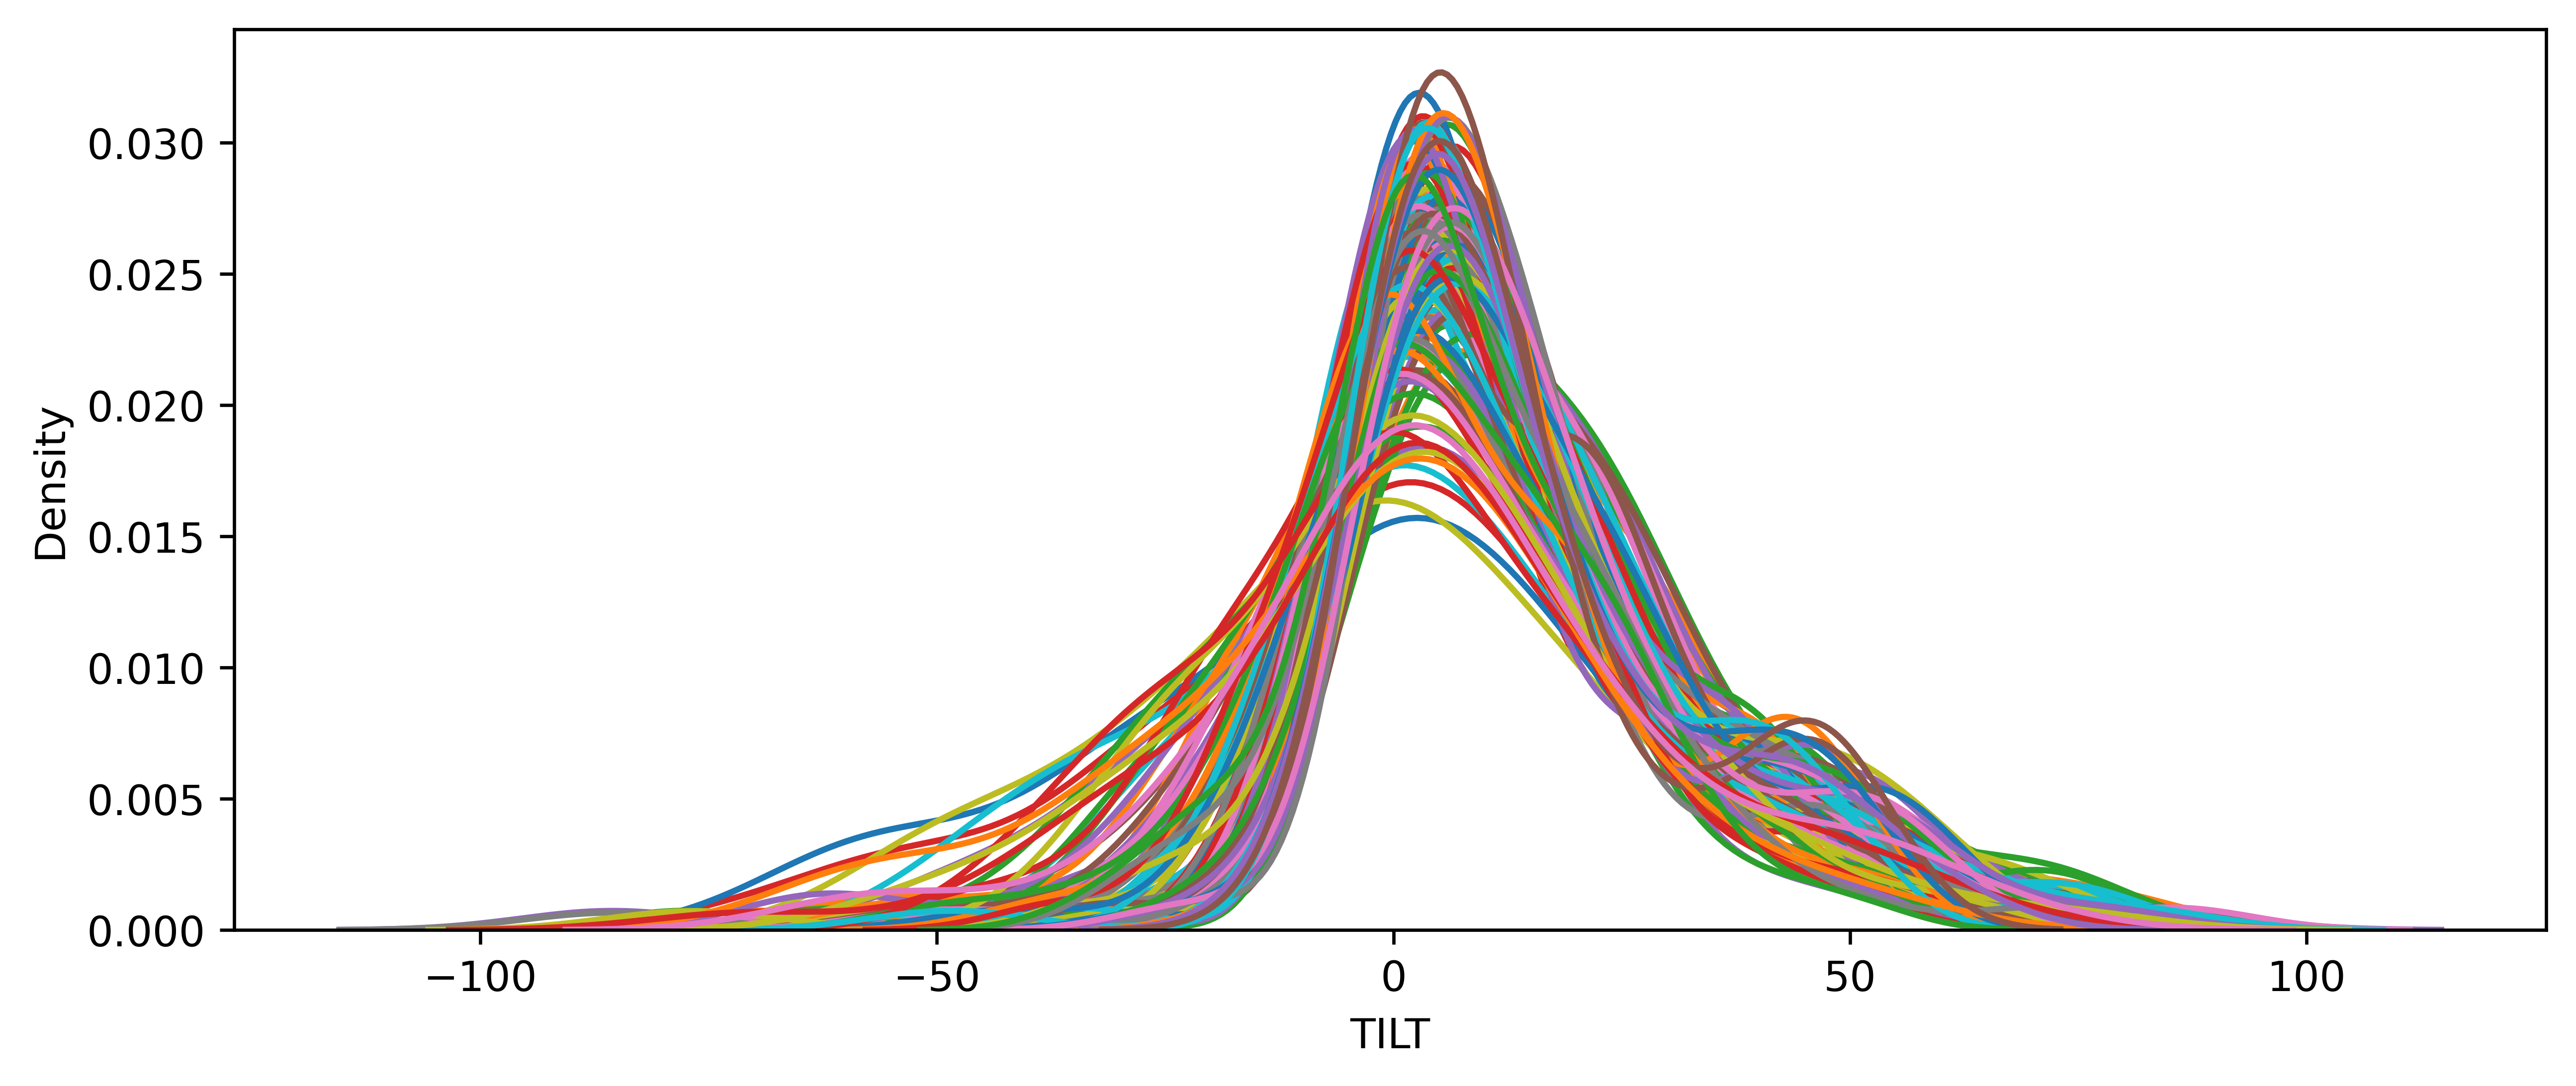

In [28]:
# plot figure
fig = plt.figure(figsize = (10, 4), dpi = 600)

# plot map data
for data in data_to_plot:
    sns.kdeplot(x=data['TILT'])

In [21]:
([np.std(data['TILT']) for data in data_to_plot])

[19.00097405214311,
 18.246519086353285,
 16.768833695440325,
 18.421859645592427,
 23.684992312788673,
 15.409321251048066,
 16.80589713966698,
 16.683672996467333,
 15.02997587101624,
 20.01255124831675,
 18.26678324110434,
 19.905755599282703,
 18.671505550750087,
 24.694239186876345,
 17.352687544896945,
 17.886375811367095,
 16.566434335660688,
 17.21693718849819,
 18.04371491167017,
 17.15107752365185,
 25.797778771375366,
 21.406210104836827,
 21.119085488500332,
 18.529577159407232,
 17.665409035183977,
 20.739986524061035,
 18.21740798756817,
 18.949518125981502,
 18.828121128639168,
 19.50795400264818,
 20.145339957960026,
 16.970347336142705,
 20.89918631045086,
 16.623851290897548,
 17.2507148697404,
 19.65430314223291,
 18.43538670172273,
 16.191853401159598,
 19.038983494105025,
 15.185460948054828,
 16.24110740809861,
 22.29671200933563,
 19.549777090321417,
 17.461391339723374,
 18.49912938211228,
 18.005474403949275,
 17.31647903456967,
 14.522153100288062,
 23.7379442

<AxesSubplot:ylabel='Density'>

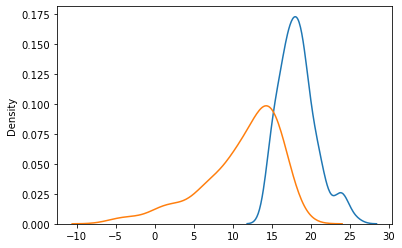

In [19]:
sns.kdeplot(data=[np.std(data['TILT']) for data in flow_data])
sns.kdeplot(data=[np.mean(data['TILT']) for data in flow_data])